## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Calibration and undistortion for chessboard images

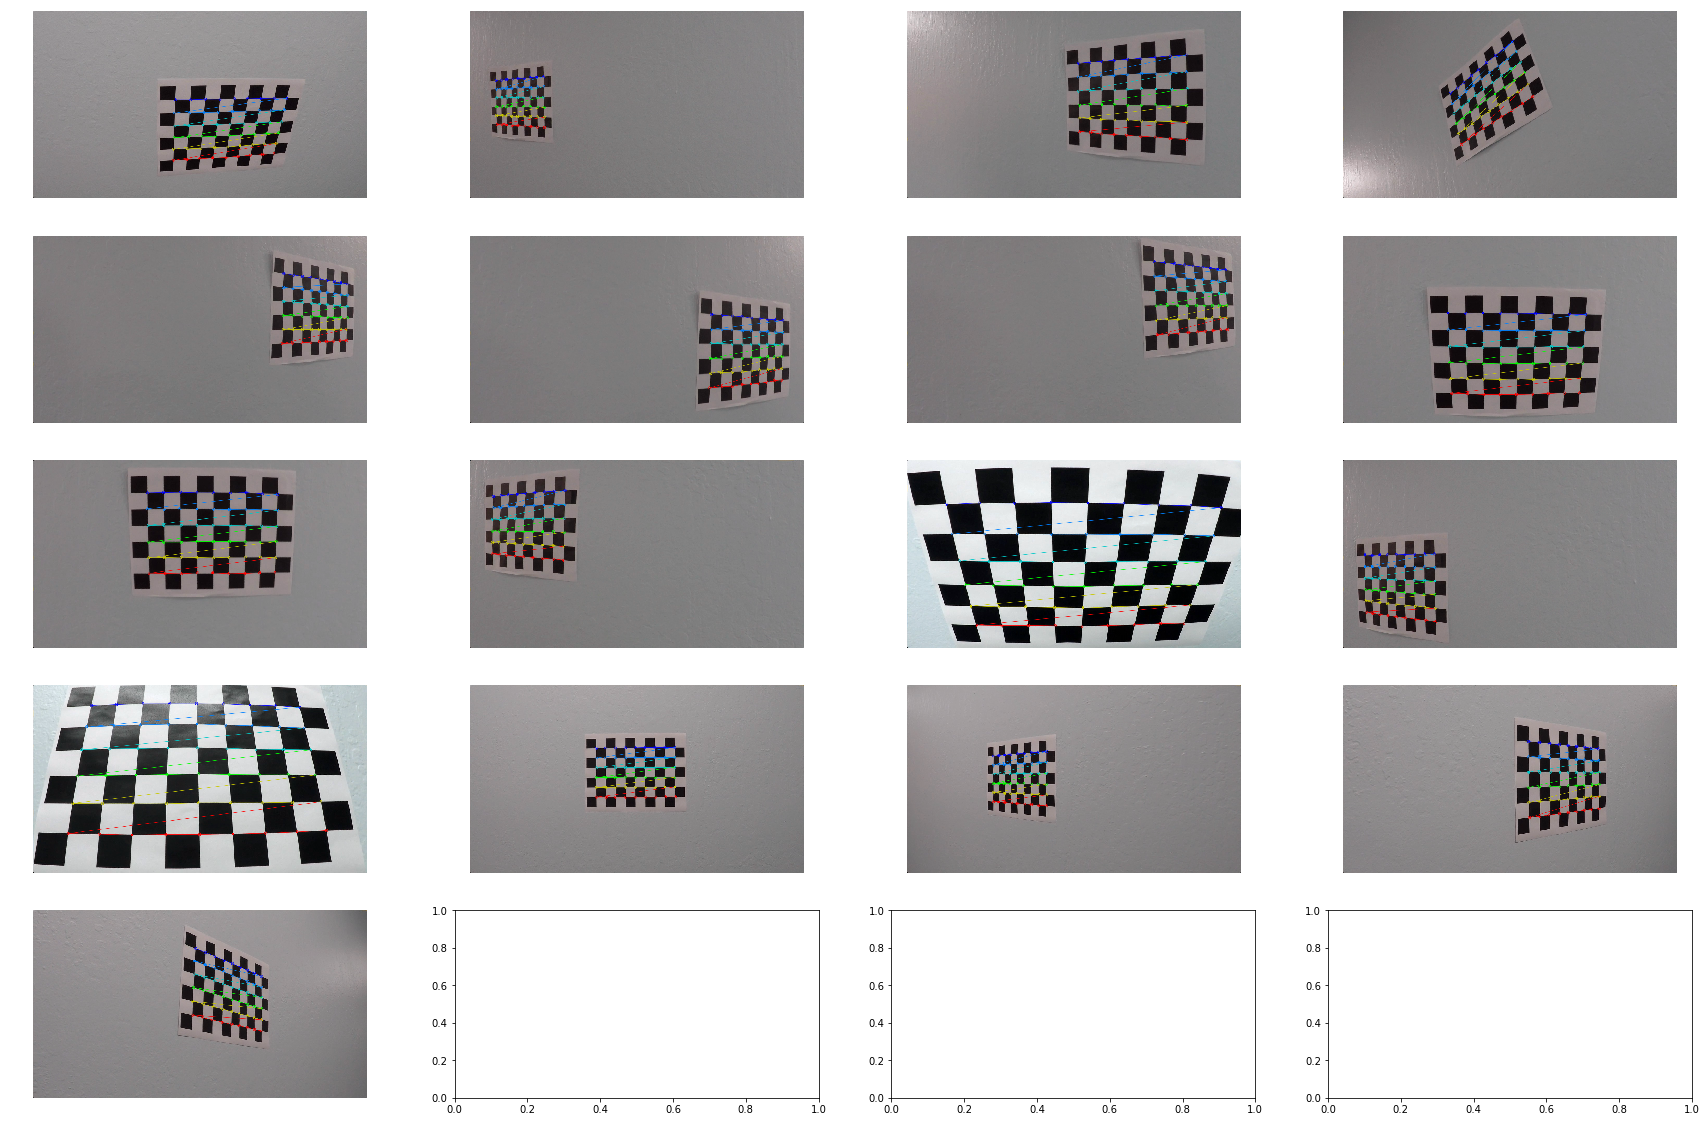

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5, 4, figsize=(30, 20))
axs = axs.ravel()

# Step through the list and search for chessboard corners
i = 0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        axs[i].axis('off')
        axs[i].imshow(img)
        
        i = i + 1

plt.savefig('./output_images/calibration-chessboard')

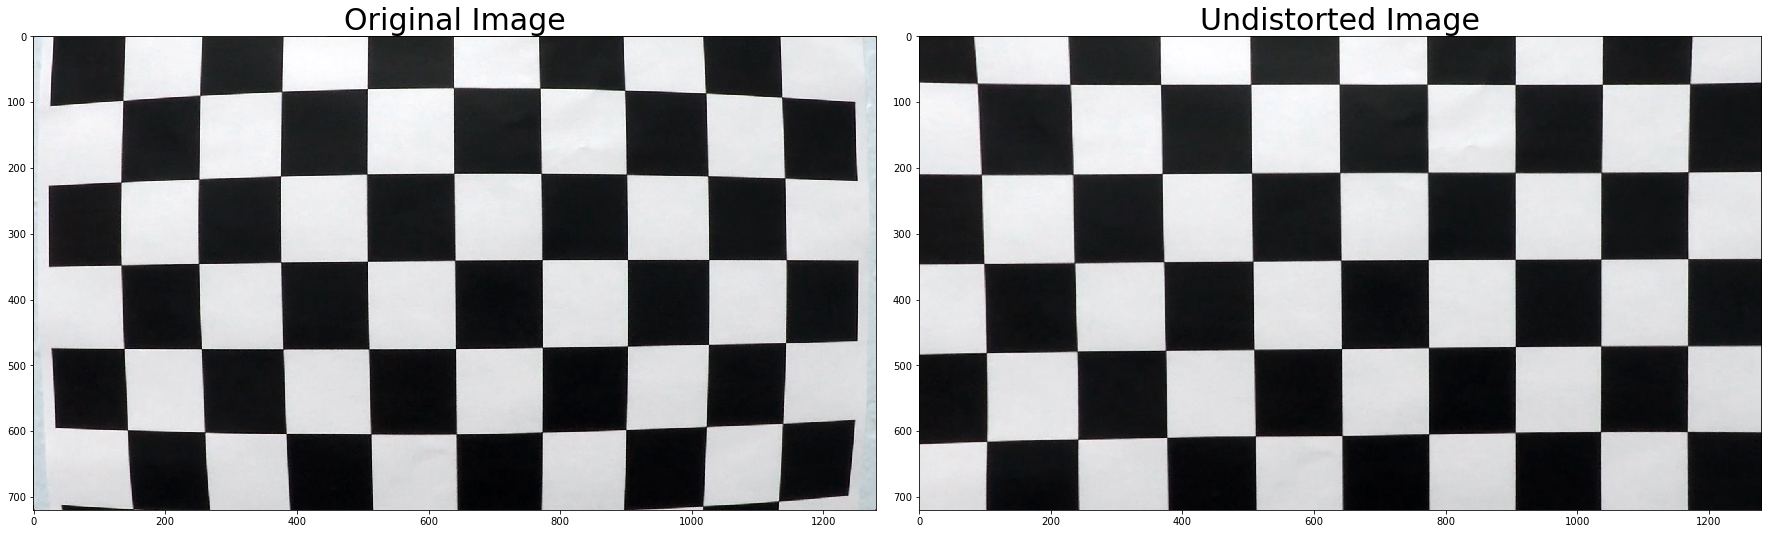

In [2]:
img = cv2.imread('./camera_cal/calibration1.jpg')
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/undistortion-chessboard')

## Undistortion for road images

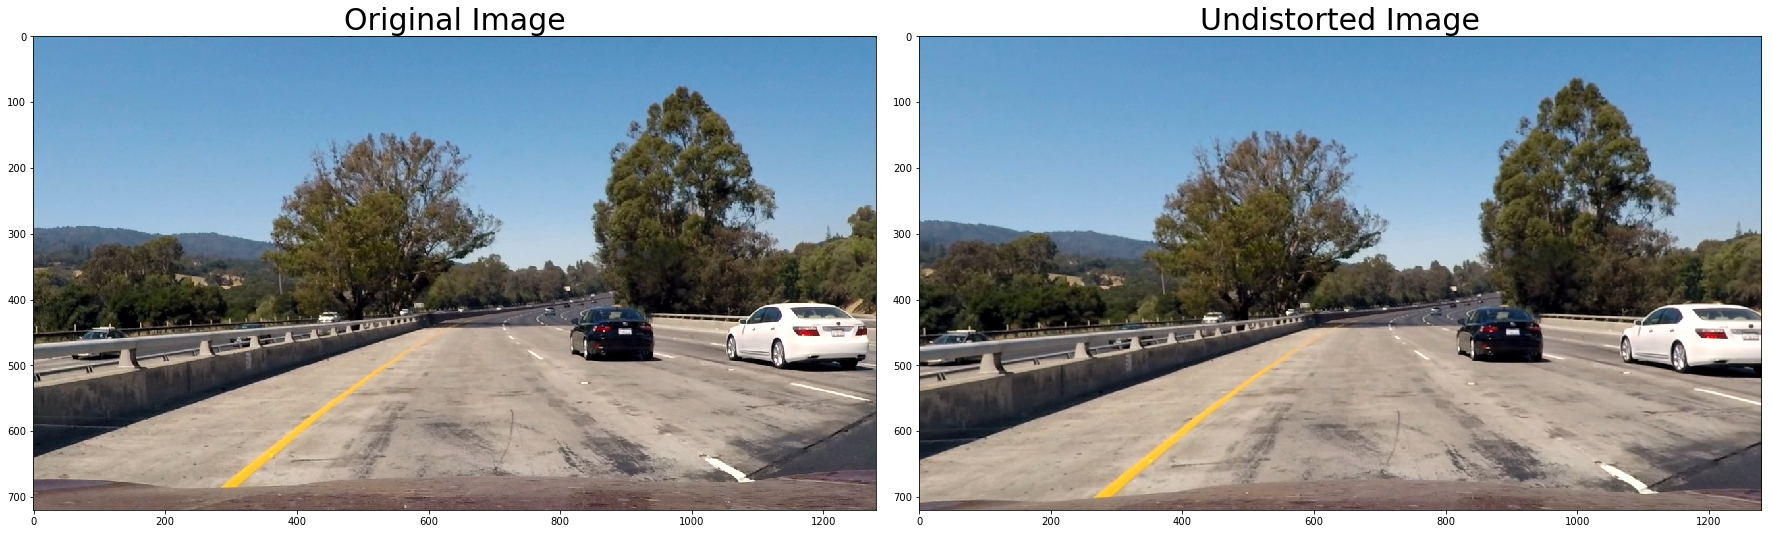

In [11]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/undistortion-lane')

## Color transforms and gradients to create thresholded binary images

In [4]:
def pipeline(img, r_thresh=(180, 255), s_thresh=(80, 255), sx_thresh=(20, 100), sobel_kernel=3):
    
    img = np.copy(img)
    
    # Separate the R channel
    r_channel = img[:,:,0]
    # Threshold R channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack((r_binary, s_binary, sx_binary))
    
    # Combine the three binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    
    combined_binary[((r_binary == 1) & (s_binary == 1)) | 
                    ((s_binary == 1) & (sx_binary == 1)) |
                    ((sx_binary == 1) & (r_binary == 1))] = 1

    return r_binary, s_binary, sx_binary, color_binary, combined_binary

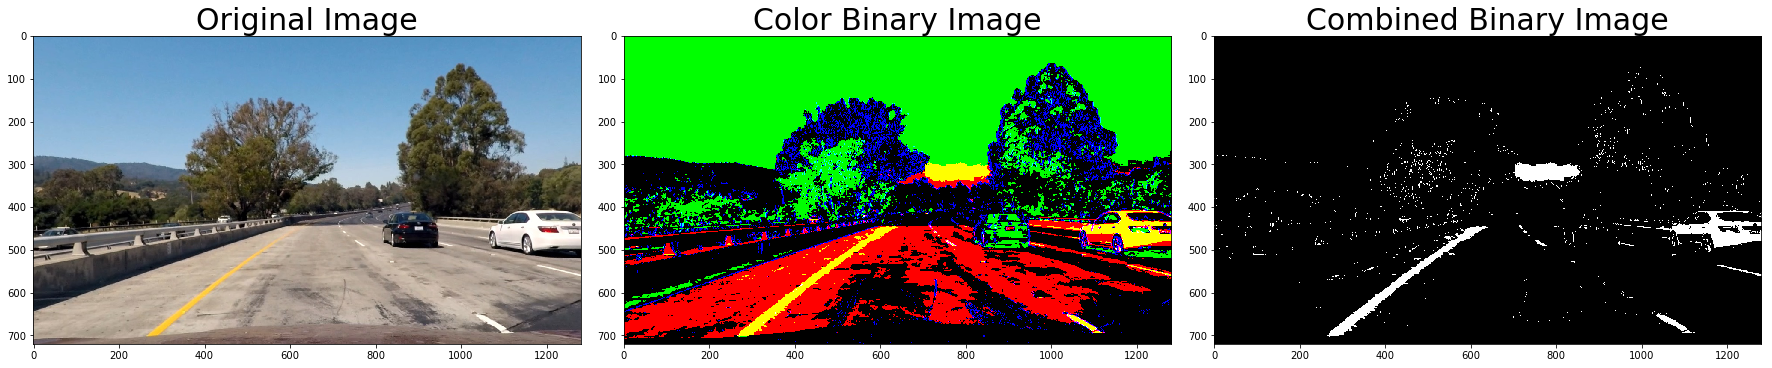

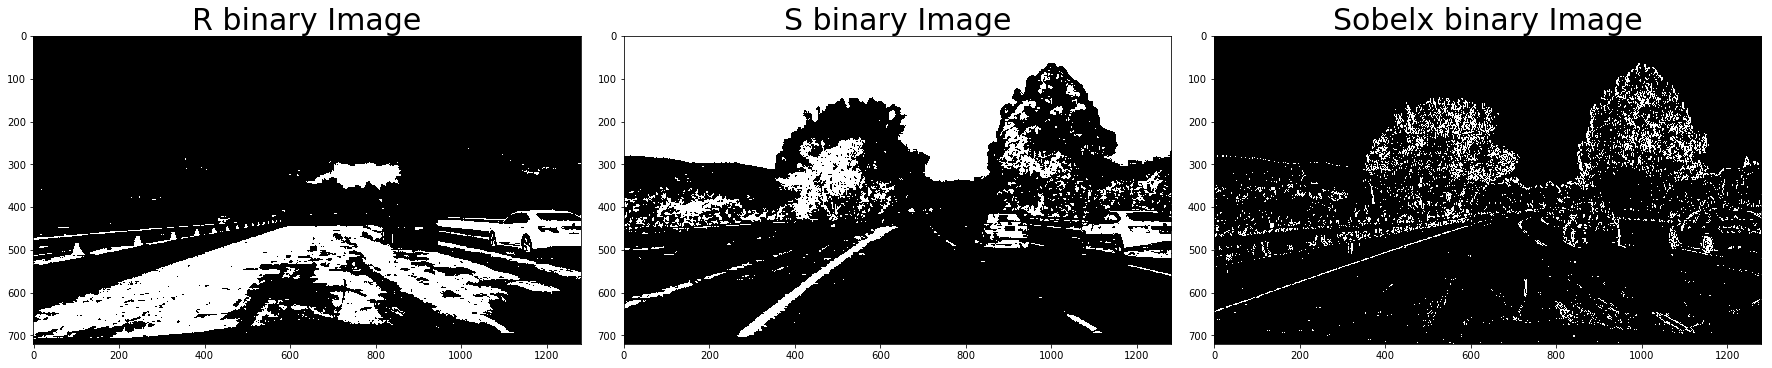

In [14]:
r_binary, s_binary, sx_binary, color_binary, combined_binary = pipeline(undist)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(color_binary)
ax2.set_title('Color Binary Image', fontsize=30)
ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(r_binary, cmap='gray')
ax1.set_title('R binary Image', fontsize=30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S binary Image', fontsize=30)
ax3.imshow(sx_binary, cmap='gray')
ax3.set_title('Sobelx binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/binary-images')

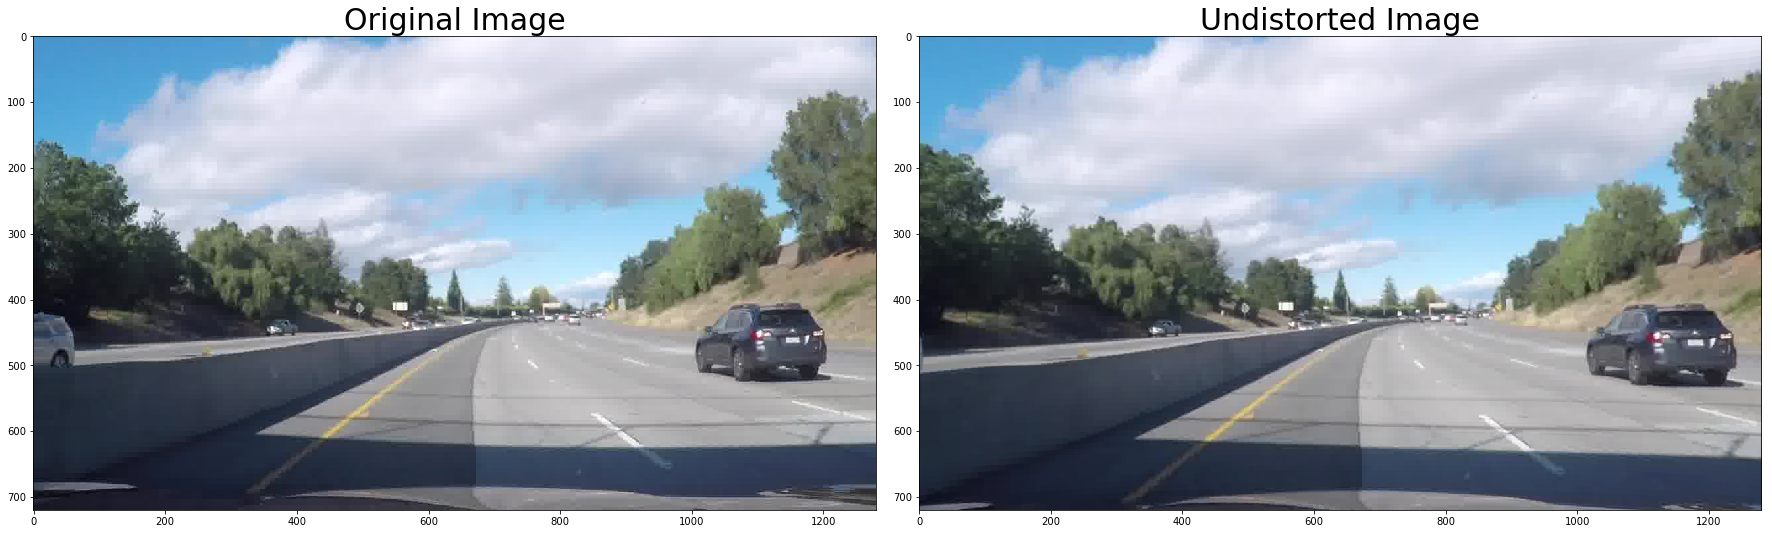

In [6]:
img = cv2.imread('./challenge_video_frames/0156.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

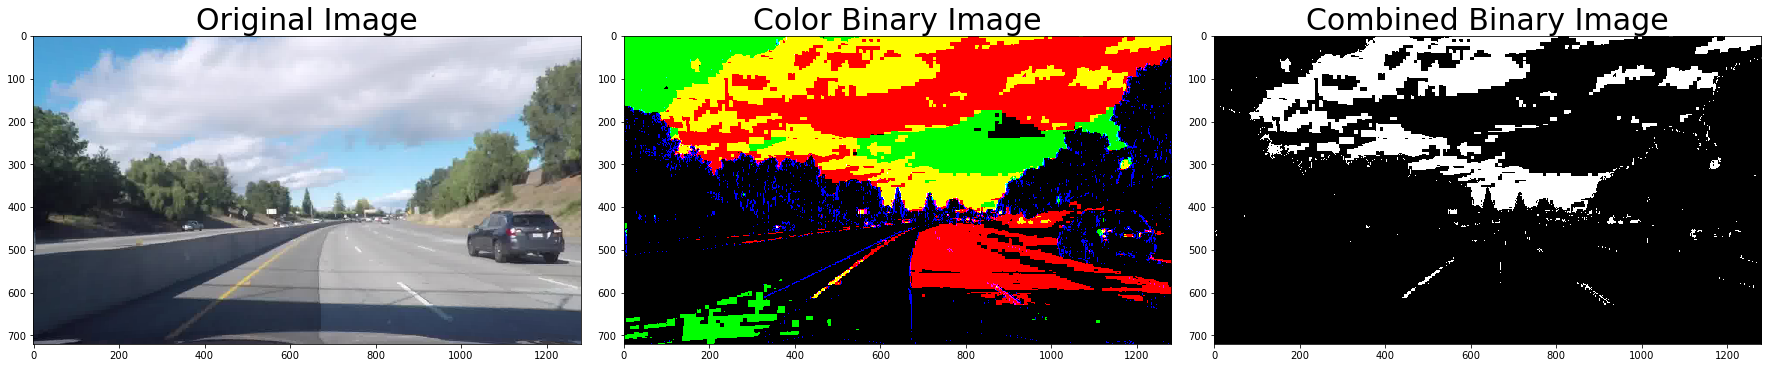

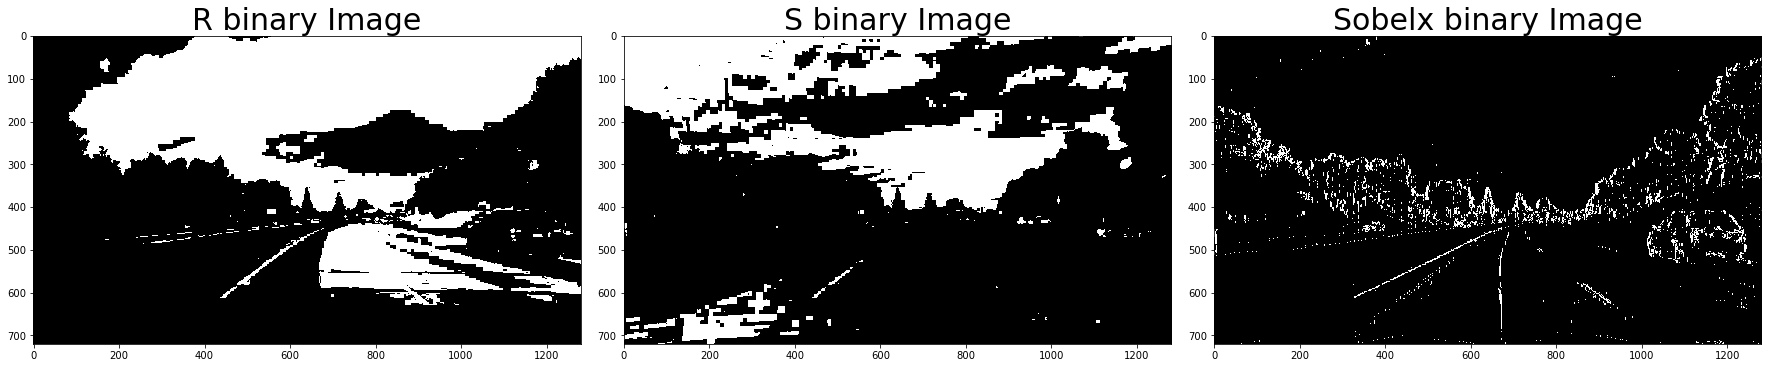

In [7]:
r_binary, s_binary, sx_binary, color_binary, combined_binary = pipeline(undist)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(color_binary)
ax2.set_title('Color Binary Image', fontsize=30)
ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(r_binary, cmap='gray')
ax1.set_title('R binary Image', fontsize=30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S binary Image', fontsize=30)
ax3.imshow(sx_binary, cmap='gray')
ax3.set_title('Sobelx binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

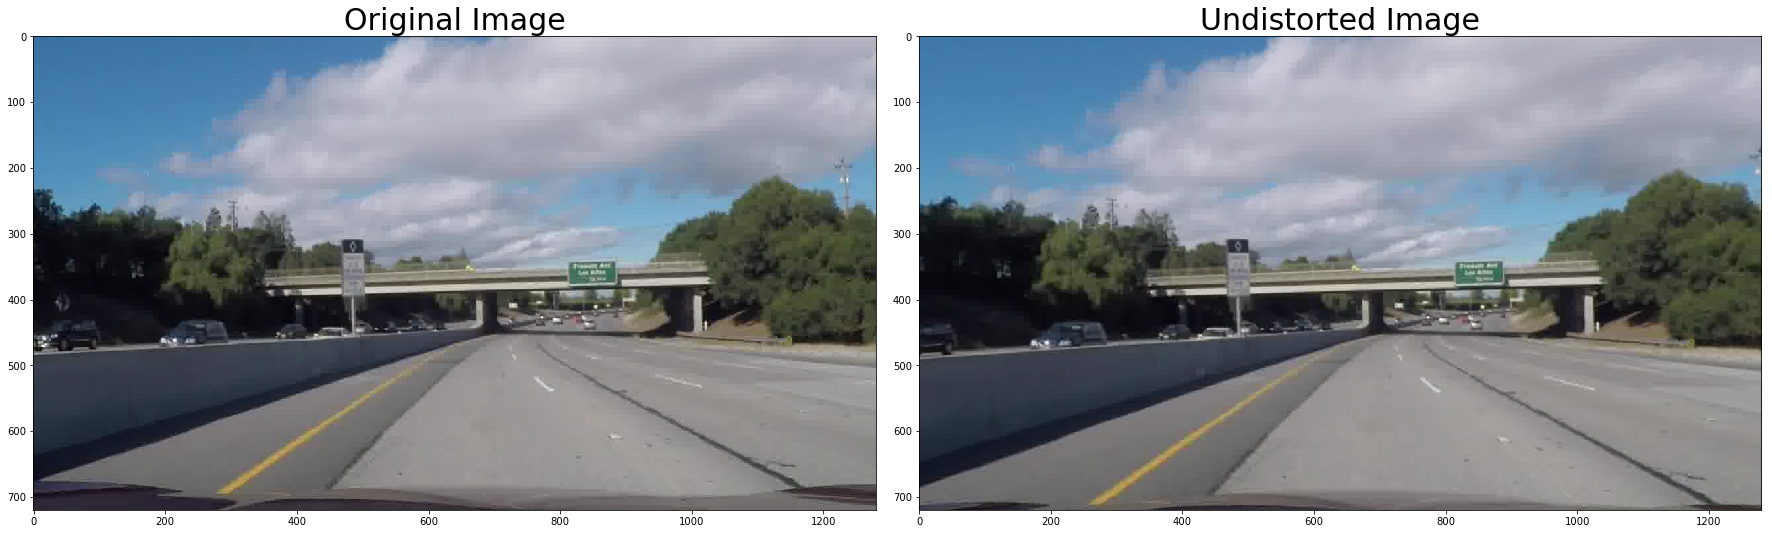

In [8]:
img = cv2.imread('./challenge_video_frames/0051.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

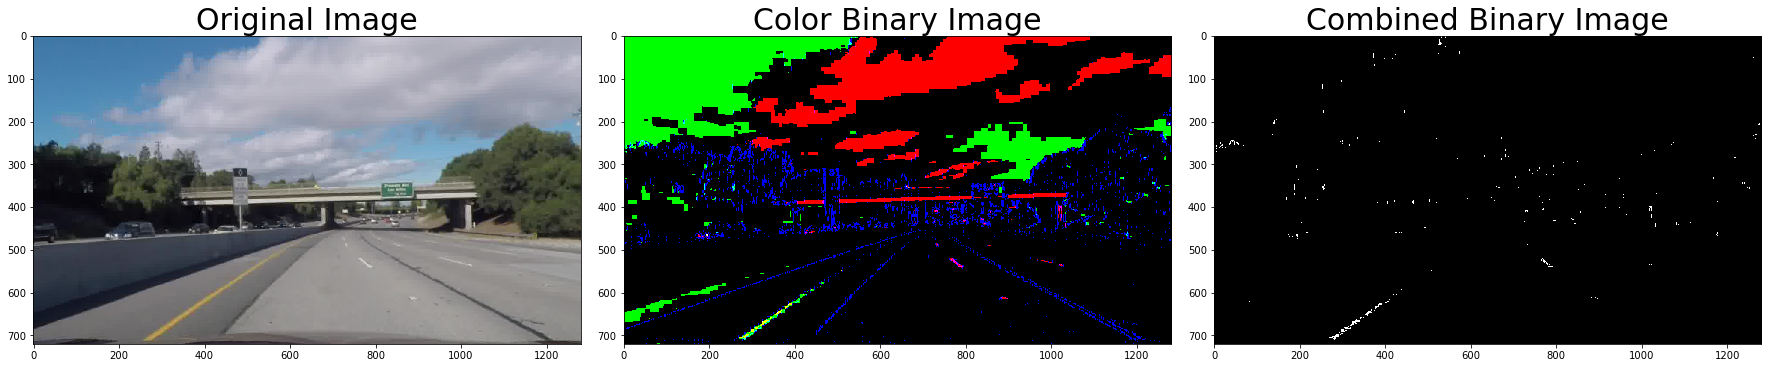

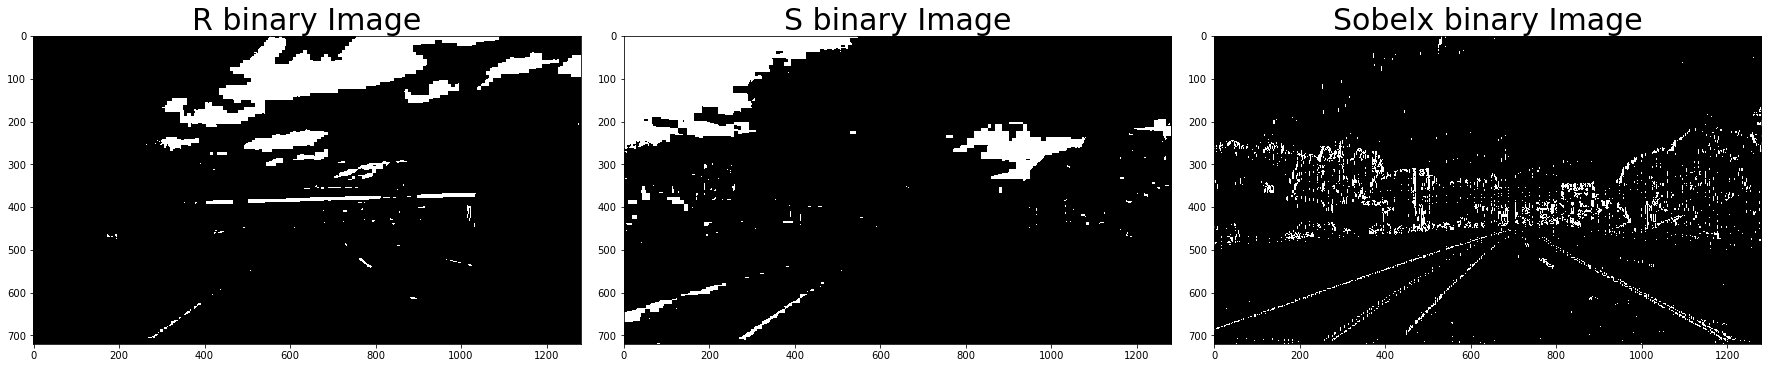

In [9]:
r_binary, s_binary, sx_binary, color_binary, combined_binary = pipeline(undist)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(color_binary)
ax2.set_title('Color Binary Image', fontsize=30)
ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(r_binary, cmap='gray')
ax1.set_title('R binary Image', fontsize=30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S binary Image', fontsize=30)
ax3.imshow(sx_binary, cmap='gray')
ax3.set_title('Sobelx binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transfomation

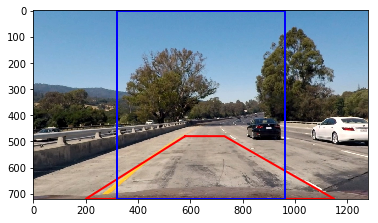

In [12]:
# Check
plt.plot([580, 180, 1180, 730, 580], [450, 720, 720, 450, 450], 'r', lw=2)
plt.plot([320, 320, 960, 960, 320], [0, 720, 720, 0, 0], 'b', lw=2)
plt.imshow(undist)

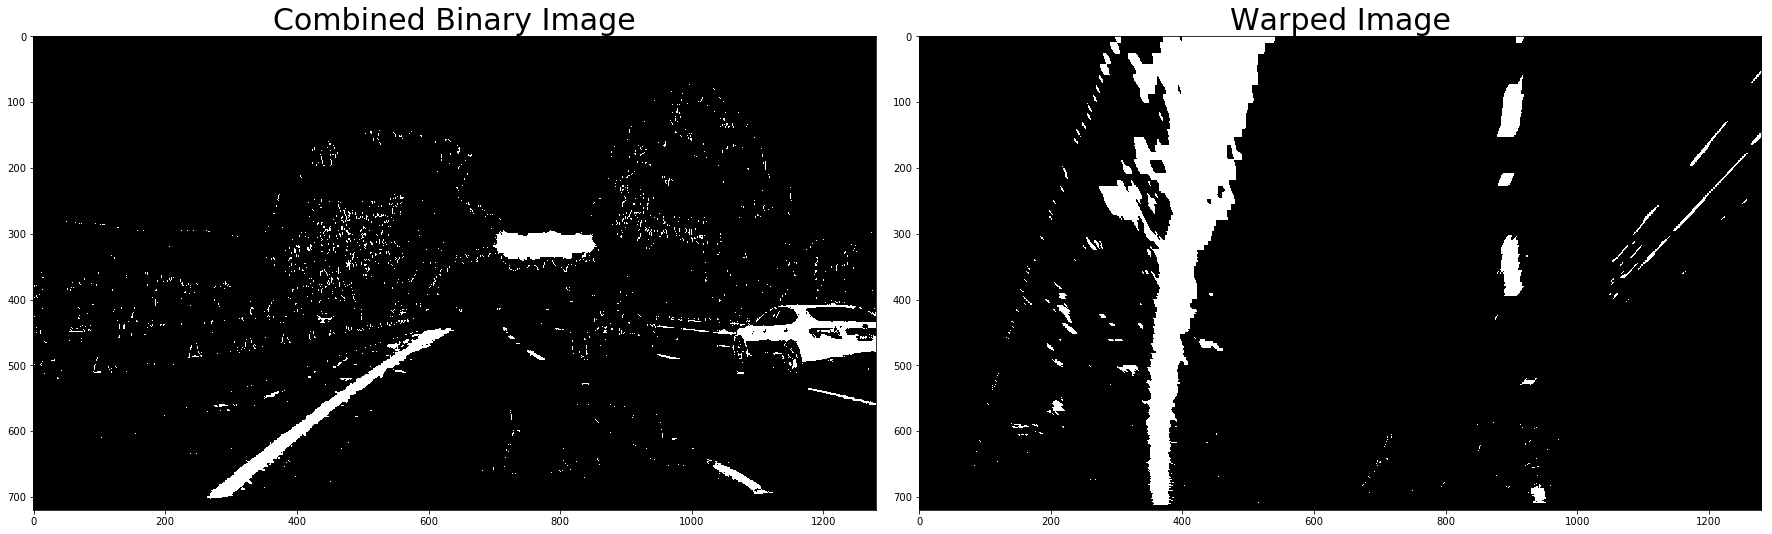

In [15]:
src_coord = np.float32([[580, 450], [180, 720], [1180, 720], [730, 450]])
dst_coord = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M = cv2.getPerspectiveTransform(src_coord, dst_coord)
Minv = cv2.getPerspectiveTransform(dst_coord, src_coord)

warped = cv2.warpPerspective(combined_binary, M, combined_binary.shape[::-1], flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined Binary Image', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/warped')

## Detect lane lines by sliding window

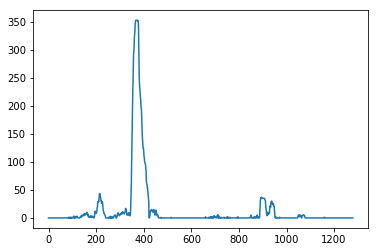

In [16]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

plt.savefig('./output_images/histogram')

In [17]:
def find_lines(img):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit = None, None
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, leftx, lefty, rightx, righty, left_fit, right_fit

out_img, leftx, lefty, rightx, righty, left_fit, right_fit = find_lines(warped)

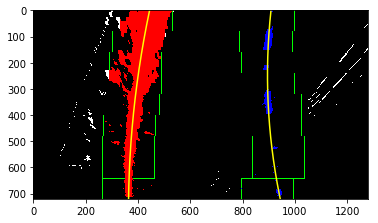

In [18]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('./output_images/find-lane')

In [19]:
def find_lines2(img, left_fit, right_fit):

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit, right_fit = None, None
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    return leftx, lefty, rightx, righty, left_fit, right_fit

leftx, lefty, rightx, righty, left_fit, right_fit = find_lines2(warped, left_fit, right_fit)

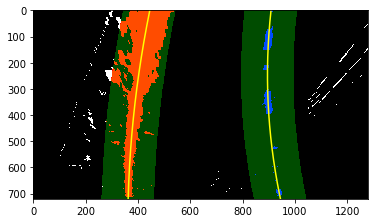

In [20]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

margin = 100

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('./output_images/search-window')

## Calculate the curvature of the lane and the offset of vehicle position from the center

In [21]:
def get_curvature(img, leftx, lefty, rightx, righty, left_fit, right_fit):

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    #leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    curverad = np.mean([left_curverad, right_curverad])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    img_mid = img.shape[1] / 2
    leftx_base = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
    rightx_base = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
    lane_mid = (leftx_base + rightx_base) / 2
    offset = (img_mid - lane_mid) * xm_per_pix
    
    return left_curverad, right_curverad, curverad, offset

left_curverad, right_curverad, curverad, offset = get_curvature(warped, leftx, lefty, rightx, righty, left_fit, right_fit)
print(left_curverad, right_curverad, curverad, offset)

1344.56345316 742.354899516 1043.45917634 -0.0720731564117


## Unwarp and draw lane area

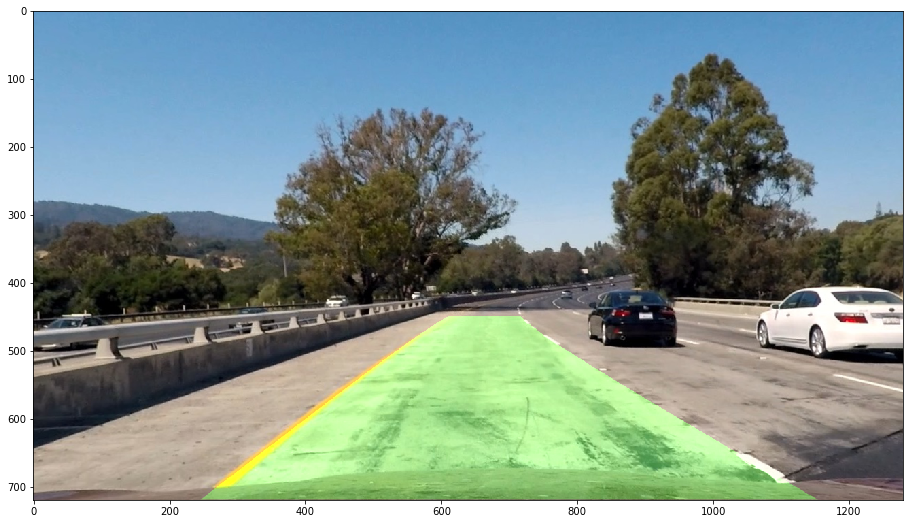

In [22]:
def draw_lane(undist, warped, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

result = draw_lane(undist, warped, left_fit, right_fit, Minv)

plt.subplots(1, 1, figsize=(24, 9))
plt.imshow(result)

plt.savefig('./output_images/lane-area')

## Define functions for processing videos

In [23]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        # x values of the last fit
        self.last_x = np.array([None,None,None], dtype='float')

In [24]:
# preparation
src_coord = np.float32([[580, 450], [180, 720], [1180, 720], [730, 450]])
dst_coord = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M = cv2.getPerspectiveTransform(src_coord, dst_coord)
Minv = cv2.getPerspectiveTransform(dst_coord, src_coord)

In [41]:
def process_image(img):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    _, _, _, _, combined_binary = pipeline(undist)
    
    warped = cv2.warpPerspective(combined_binary, M, combined_binary.shape[::-1], flags=cv2.INTER_LINEAR)
    
    if not left_line.detected or not right_line.detected:
        _, leftx, lefty, rightx, righty, left_fit, right_fit = find_lines(warped)
    else:
        leftx, lefty, rightx, righty, left_fit, right_fit = find_lines2(warped, left_line.best_fit, right_line.best_fit)
    
    ### sanity check
    if left_fit is not None and right_fit is not None:
        succeed = True
    else:
        succeed = False
    
    if succeed:
        leftx_base = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
        rightx_base = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
        
        leftx_mid = left_fit[0]*img.shape[0]/2**2 + left_fit[1]*img.shape[0]/2 + left_fit[2]
        rightx_mid = right_fit[0]*img.shape[0]/2**2 + right_fit[1]*img.shape[0]/2 + right_fit[2]
        
        leftx_top = left_fit[2]
        rightx_top = right_fit[2]
        
        if left_line.last_x is not None and right_line.last_x is not None:
            leftx_base_diff = abs(left_line.last_x[0] - leftx_base)
            leftx_mid_diff = abs(left_line.last_x[1] - leftx_mid)
            leftx_top_diff = abs(left_line.last_x[2] - leftx_top)
            rightx_base_diff = abs(right_line.last_x[0] - rightx_base)
            rightx_mid_diff = abs(right_line.last_x[1] - rightx_mid)
            rightx_top_diff = abs(right_line.last_x[2] - rightx_top)
        
            if leftx_base_diff > 50 or leftx_mid_diff > 50 or leftx_top_diff > 50 or rightx_base_diff > 50 or rightx_mid_diff > 50 or rightx_top_diff > 50:
                succeed = False
        
        left_line.last_x[0] = leftx_base
        left_line.last_x[1] = leftx_mid
        left_line.last_x[2] = leftx_top
        right_line.last_x[0] = rightx_base
        right_line.last_x[1] = rightx_mid
        right_line.last_x[2] = rightx_top
    ### end of sanity check
    
    if succeed:
        left_line.detected = True
        right_line.detected = True
        left_line.current_fit.append(left_fit)
        right_line.current_fit.append(right_fit)
        if len(left_line.current_fit) > 5:
            left_line.current_fit = left_line.current_fit[1:]
        if len(right_line.current_fit) > 5:
            right_line.current_fit = right_line.current_fit[1:]
        left_line.allx = leftx
        left_line.ally = lefty
        right_line.allx = rightx
        right_line.ally = righty       
    else:
        left_line.detected = False
        right_line.detected = False
    
    if len(left_line.current_fit) < 1 or len(right_line.current_fit) < 1: # it means best_fit doesn't exist
        result = undist
    else:
        left_line.best_fit = np.mean(left_line.current_fit, axis=0)
        right_line.best_fit = np.mean(right_line.current_fit, axis=0)

        _, _, curverad, offset = get_curvature(warped, left_line.allx, left_line.ally, right_line.allx, right_line.ally, left_line.best_fit, right_line.best_fit)

        cv2.putText(undist, 'Radius of Curvature = {}(m)'.format(int(curverad)), (30,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(undist, 'Vehicle is {:.2f}m {} of center'.format(np.absolute(offset), 'right' if offset >= 0 else 'left'), (30,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        result = draw_lane(undist, warped, left_line.best_fit, right_line.best_fit, Minv)
    
    ### diagnosis
    diag_img = np.zeros((720,1280,3), dtype=np.uint8)
    diag_img[0:720,0:920,:] = cv2.resize(result,(920,720))
    diag_img[0:360,920:1280,:] = cv2.resize(np.dstack((combined_binary*255, combined_binary*255, combined_binary*255)),(360,360))
    cv2.putText(diag_img[0:360,920:1280,:], 'Thresholded', (200,40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
    
    warped = np.dstack((warped, warped, warped))*255
    
    if result is not undist:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
        right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]

        warped[left_line.ally, left_line.allx] = [255, 0, 0]
        warped[right_line.ally, right_line.allx] = [0, 0, 255]
        left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(warped, np.int32([left_pts]), isClosed=False, color=(255,255,0), thickness=8)
        cv2.polylines(warped, np.int32([right_pts]), isClosed=False, color=(255,255,0), thickness=8)
    
    diag_img[360:720,920:1280,:] = cv2.resize(warped, (360,360))
    cv2.putText(diag_img[360:720,920:1280,:], 'Bird-eye view', (170,40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
    ### end of diagnosis
    
    return diag_img

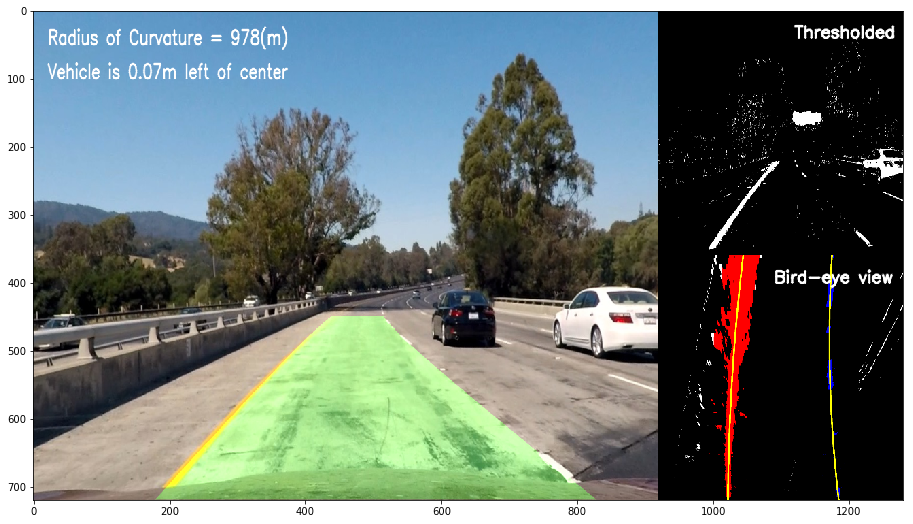

In [42]:
left_line = Line()
right_line = Line()

img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = process_image(img)

plt.subplots(1, 1, figsize=(24, 9))
plt.imshow(result)

plt.savefig('./output_images/final-output')

## Process videos frame by frame and make video outputs

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
output_video = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:13<00:00,  6.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 59s, sys: 1min 3s, total: 5min 2s
Wall time: 3min 14s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [46]:
output_video = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:58<00:00,  8.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 24s, sys: 12.9 s, total: 1min 37s
Wall time: 58.9 s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [48]:
output_video = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:32<00:00,  6.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 4min 12s, sys: 1min 4s, total: 5min 17s
Wall time: 3min 33s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))